# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** 

Kristoffer Landsnes

&

Arthur Gassner (250089)

**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

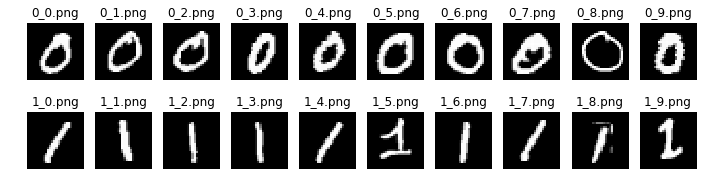

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# 1.2 Fourier descriptors


## 1.2.1 Implementation details

The 


In [175]:
import numpy as np
import matplotlib.pyplot as plt
import cmath 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from skimage import measure

In [176]:
def contour2matrix(contour, shape):
    """
    Convert contour to matrix
    """
    contour_matrix = np.zeros(shape)
    for x, y in zip(contour[:,1], contour[:,0]):
        contour_matrix[int(round(y)),int(round(x))] = 1
        
    return contour_matrix

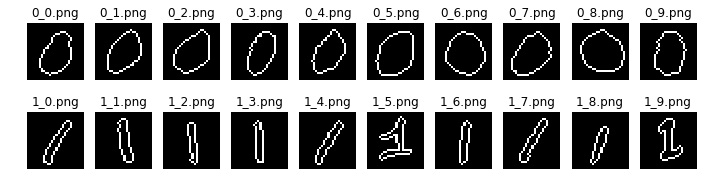

In [214]:
def get_contour(img, 
                iso_value=100):
    """
    Return the biggest contour (as a matrix) found in the img
    """
    # Find contours at a constant value of 100
    contours = measure.find_contours(img, 100)
    
    # Sort contours so that the contour with the 
    # biggest amount of points will be first
    contours.sort(key = lambda c: c.shape[0], reverse=True)
    
    contour = contours[0]
    
    return contour

### TEST RUN ###

# Display the image and plot all contours found

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    c = get_contour(im)
    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    c = get_contour(im)
    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [178]:
def compute_complex_signal(contour):
    """
    Take a contour (i.e. a Nx2 matrix with the (x,y) coordinates
    of the N points)
    Return a Nx1 matrix of successive complex points, where u = x + j*y
    """
    complex_signal = []
    for x, y in zip(contour[:,1], contour[:,0]):
        u = x + y*1j
        complex_signal.append(u)
    return complex_signal

In [199]:
def compute_fourier_descriptor(complex_signal, l):
    """
    Return the lth fourier descriptor of complex_signal
    A fourier descriptor is a complex number
    """
    N = len(complex_signal)
    
    fl = 0
    for k in range(0, N):
        uk = complex_signal[k]
        exponant = -2*cmath.pi*k*l/N*1j
        fl += uk*cmath.exp(exponant)
    return fl

In [200]:
def get_abs_fl(l, img):
    """
    l : lth of the fourier descriptor to extract
    Take a black and white img
    Return a real number, 
    representing the amplitudes of the fourier descriptor 
    """
    c = get_contour(img)
    cs = compute_complex_signal(c)
    
    return abs(compute_fourier_descriptor(cs, l))

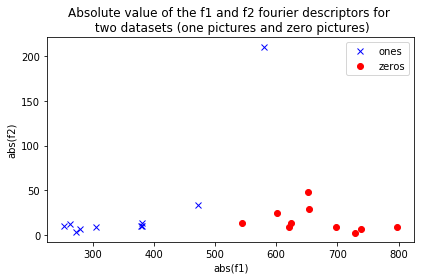

In [205]:
# PLOT THE AMPLITUDE OF THE FIRST 2 FOURIER DESCRIPTORS (F1 AND F2)

# record ones' features
ones_features = [[],[]]    
for im in ones_im:
    for i, l in enumerate(range(1,3)):
        abs_fl = get_abs_fl(l, im)
        ones_features[i].append(abs_fl)

# record zeros' features
zeros_features = [[],[]]    
for im in zeros_im:
    for i, l in enumerate(range(1,3)):
        abs_fl = get_abs_fl(l, im)
        zeros_features[i].append(abs_fl)

# plot in 2D
plt.plot(ones_features[0], ones_features[1], 'bx')
plt.plot(zeros_features[0], zeros_features[1], 'ro')


# make things pretty
plt.xlabel("abs(f1)")
plt.ylabel("abs(f2)")
plt.legend(["ones", "zeros"])
plt.title("Absolute value of the f1 and f2 fourier descriptors for \n two datasets (one pictures and zero pictures)")

plt.tight_layout()

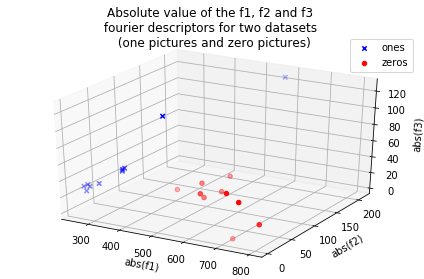

In [206]:
# PLOT THE AMPLITUDE OF THE FIRST 3 FOURIER DESCRIPTORS (F1, F2 AND F3)

# record ones' features
ones_features = [[], [], []]    
for im in ones_im:
    for i, l in enumerate(range(1,4)):
        abs_fl = get_abs_fl(l, im)
        ones_features[i].append(abs_fl)

# record zeros' features
zeros_features = [[],[], []]    
for im in zeros_im:
    for i, l in enumerate(range(1,4)):
        abs_fl = get_abs_fl(l, im)
        zeros_features[i].append(abs_fl)

# PLOT IN 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c, m, features in [('b', 'x', ones_features), ('r', 'o', zeros_features)]:
    xs = features[0]
    ys = features[1]
    zs = features[2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('abs(f1)')
ax.set_ylabel('abs(f2)')
ax.set_zlabel('abs(f3)')
ax.legend(["ones", "zeros"])
ax.set_title("Absolute value of the f1, f2 and f3 \n fourier descriptors for two datasets  \n (one pictures and zero pictures)")
fig.tight_layout()

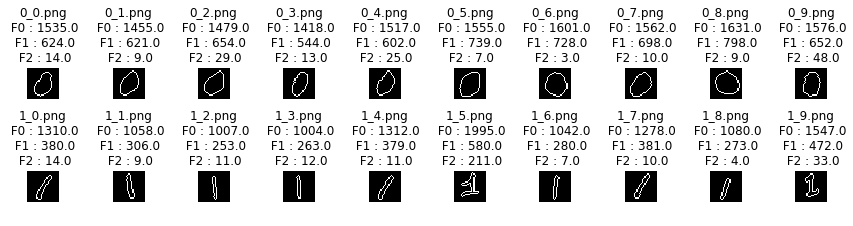

In [182]:
### SHOW DESCRIPTORS OF PICS ###

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    c = get_contour(im)
    cs = compute_complex_signal(c)
    
    title = nm
    for l in range(0,3):
        fl = compute_fourier_descriptor(cs, l)
        title += "\n F" + str(l) + " : " + str(round(abs(fl)))

    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    c = get_contour(im)
    cs = compute_complex_signal(c)
    
    title = nm
    for l in range(0,3):
        fl = compute_fourier_descriptor(cs, l)
        title += "\n F" + str(l) + " : " + str(round(abs(fl)))

    ax.imshow(contour2matrix(c, im.shape), cmap='gray')
    ax.axis('off')
    ax.set_title(title)
    
plt.tight_layout()

In [183]:
## TODO

# - SHOW THAT THE STARTING POINT ONLY AFFECTS THE PHASE, NOT THE AMPLITUDE
# - SHOW THAT TRANSLATION ONLY CHANGES F0
# - SHOW THAT ROTATION ONLY CHANGE THE PHASE, NOT THE AMPLITUDE
# - SHOW THAT SCALING DOES NOT CHANGE THE RATIO OF THE AMPLITUTDE
# - USE 3 DESCRIPTORS INSTEAD OF 2
# - TALK ABOUT THE WEIRD ONE

# 1.3 Additional method(s)

# pca

# ica

# do region detection and find the one with eccentricty (or moment)

# do bounding box, and with the one with high width/height ratio

(At least 3 additional (on top of fourier) to have 6)


# 1.3a Threshold, region detection and eccentricity

We will first use a histogram to find a good threshold. We then threshold the picture and apply region detection.

When looking at the shape of 1's and 0's, one can expect the eccentricity of 1's to be higher than the ones of 0's.

# 1.3b Threshold, region detection and holes

We will first use a histogram to find a good threshold. We then threshold the picture and apply region detection.